In [4]:
######## GLOBAL ########
import random
import pandas as pd
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [ ]:
#create corpora, split into train and test, and save as .txt files

#create dom/sub/full (combined) corpora by species
def create_corpus_by_species(df, name: str, by_length=True):

    #for each species:
    for species, species_df in df.groupby('species'):
        dom_filename  = f"corpus_{species}_{name}_dom.txt"
        sub_filename  = f"corpus_{species}_{name}_sub.txt"
        full_filename = f"corpus_{species}_{name}_full.txt"

        #group df by trial and sequence
        grouped = species_df.groupby(['trial_id', 'sequence_id'])

        with open(dom_filename, 'w') as f, open(sub_filename, 'w') as g, open(full_filename, 'w') as h:
            for (trial_id, seq_id), group in grouped:
                #dom, then sub
                for idx, fish_role in enumerate(['dom', 'sub']):
                    role_group = group[group['fish_id'] == fish_role].sort_values('order_id')
                    sequence_parts = []
                    for _, row in role_group.iterrows():
                        #by_length repetition
                        if by_length:
                            chars = [str(row['state'])] * int(row['length'])
                        else:
                            chars = [str(row['state'])]

                        sequence_parts.append(''.join(chars))
                    #add bos and eos tokens
                    sequence_line = "<s>" + ''.join(sequence_parts) + '</s>\n'

                    if idx == 0: #if dom
                        f.write(sequence_line)
                    else: #else sub
                        g.write(sequence_line)

                    h.write(sequence_line)

dat = pd.read_csv('PrettyDat.csv')

random_state = 123

train_list = []
test_list = []

# Group by species and split by trial_id into train and test
for species, group in dat.groupby("species"):
    trial_ids = group["trial_id"].unique()
    train_trials, test_trials = train_test_split(
        trial_ids, test_size=0.2, random_state=random_state
    )
    
    train_subset = group[group["trial_id"].isin(train_trials)]
    test_subset = group[group["trial_id"].isin(test_trials)]
    
    train_list.append(train_subset)
    test_list.append(test_subset)

# Combine all species back
train = pd.concat(train_list).reset_index(drop=True)
test = pd.concat(test_list).reset_index(drop=True)

# Check sizes
print(f"Train set size: {len(train)} rows")
print(f"Test set size: {len(test)} rows")

create_corpus_by_species(train, name = "train", by_length=True)
create_corpus_by_species(test, name = "test", by_length=True)

In [ ]:
### HELPER FUNCTIONS ###

#read corpus by line
def read_lines(filename):
    lines = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # Remove <s> and </s>
            line = line.replace("<s>", "").replace("</s>", "").strip()
            seq = list(line)
            lines.append(seq)
    return lines

#read corresponding dom/sub corpora as aligned list of sequences
def read_both_lines(dom_filename, sub_filename):
    dom_lines = []
    sub_lines = []
    with open(dom_filename) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # Remove <s> and </s>
            line = line.replace("<s>", "").replace("</s>", "").strip()
            seq = list(line)
            dom_lines.append(seq)
        #dom_lines = [line.strip().replace("<s>", "").replace("</s>", "").split() for line in f]
    with open(sub_filename) as g:
        for line in g:
            line = line.strip()
            if not line:
                continue
            # Remove <s> and </s>
            line = line.replace("<s>", "").replace("</s>", "").strip()
            seq = list(line)
            sub_lines.append(seq)
        #sub_lines = [line.strip().replace("<s>", "").replace("</s>", "").split() for line in g]
    
    # Ensure same number of sequences
    assert len(dom_lines) == len(sub_lines), "mismatched sequence numbers :("
    return dom_lines, sub_lines

#find distribution of lengths for each state
def find_length_dists(lines):
    lengths = defaultdict(Counter)
    
    for seq in lines:
        run_char, run_len = seq[0], 1
        for s in seq[1:]:
            if s == run_char:
                run_len += 1
            else:
                lengths[run_char][run_len] += 1
                run_char, run_len = s, 1
        lengths[run_char][run_len] += 1 
    
    # normalize
    length_dists = {}
    tidy_rows = []
    for state, counter in lengths.items():
        total = sum(counter.values())
        length_dists[state] = {l: c / total for l, c in counter.items()}
        for l, c in counter.items():
            tidy_rows.append({"state": state, "length": l, "prob": c / total})
    
    #make a handy table for reference 
    df_long = pd.DataFrame(tidy_rows)

    return length_dists, df_long

#collapse sequence by length to find unique state transitions
def collapse_length(seq):
    collapsed = []
    for s in seq:
        if not collapsed or collapsed[-1] != s:
            collapsed.append(s)
    return collapsed

#Build k-order Markov transition probabilities, additive-smoothed and then normalized. 
#For train set only (needs to be smoothed to account for unobserved testing transitions)
def find_state_transitions_N(lines, k, smoother = .1):
    transitions = defaultdict(Counter)
    states = ['a','b','c','d','e','f','g','h','j','k']

    for prev in product(states, repeat=k):
        for curr in states:
            transitions[prev][curr] = smoother
    
    for seq in lines:
        collapsed = collapse_length(seq)
        if len(collapsed) <= k:
            continue
        for t in range(k, len(collapsed)):
            prev = tuple(collapsed[t - k:t])
            curr = collapsed[t]
            transitions[prev][curr] += 1

    # Normalize
    normalized = {}
    for cond, counter in transitions.items():
        total = sum(counter.values())
        normalized[cond] = {s: c / total for s, c in counter.items()}
    return normalized

#count number of k-order Markov transitions, no smoothing or normalization
#for test set only
def find_state_transitions_count(lines, k):
    transitions = defaultdict(Counter)
    
    for seq in lines:
        collapsed = collapse_length(seq)
        if len(collapsed) <= k:
            continue
        for t in range(k, len(collapsed)):
            prev = tuple(collapsed[t - k:t])
            curr = collapsed[t]
            transitions[prev][curr] += 1
    return transitions

#k-th order Markov transitions using both fish:
#Dom: P(d_t | d'_{t-k:t-1}, s_{t-1})
# #Sub: P(s_t | s'_{t-k:t-1}, d_{t-1})
#Includes additive smoothing and normalization.
def find_state_transitions_N_2F(dom_lines, sub_lines, k, smoother=0.1):
    dom_transitions = defaultdict(Counter)
    sub_transitions = defaultdict(Counter)

    states = ['a','b','c','d','e','f','g','h','j','k']
    
    for prev in product(states, repeat=k+1):
        for curr in states:
            dom_transitions[prev][curr] = smoother
            sub_transitions[prev][curr] = smoother

    for dom_seq, sub_seq in zip(dom_lines, sub_lines):
        # Collapse runs for state-based dependencies
        collapsed_dom = collapse_length(dom_seq)
        collapsed_sub = collapse_length(sub_seq)

        # Build maps from collapsed index → token index (last token of each run)
        dom_last = []
        sub_last = []
        
        run_char = dom_seq[0]
        for i, s in enumerate(dom_seq[1:], start=1):
            if s != run_char:
                dom_last.append(i - 1)
                run_char = s
        dom_last.append(len(dom_seq) - 1)
        
        run_char = sub_seq[0]
        for i, s in enumerate(sub_seq[1:], start=1):
            if s != run_char:
                sub_last.append(i - 1)
                run_char = s
        sub_last.append(len(sub_seq) - 1)
        
        L = min(len(collapsed_dom), len(collapsed_sub))
        
        # Iterate through collapsed states
        for t in range(k, L):
    
            # DOM conditional: depends on previous k dom + last sub state
            cond_dom = tuple(collapsed_dom[t-k:t]) + (sub_seq[dom_last[t-1]],)
            dom_next = collapsed_dom[t]
            dom_transitions[cond_dom][dom_next] += 1

            # SUB conditional: depends on previous k sub + last dom state
            cond_sub = tuple(collapsed_sub[t-k:t]) + (dom_seq[sub_last[t-1]],)
            sub_next = collapsed_sub[t]
            sub_transitions[cond_sub][sub_next] += 1
    
    # Normalize into probabilities
    def normalize(trans):
        return {
            cond: {k: v / sum(c.values()) for k, v in c.items()} 
            for cond, c in trans.items()
        }
    
    return normalize(dom_transitions), normalize(sub_transitions)

#count number of k-order Markov transitions using both fish, no smoothing orr normalization
#same formula as above
#for test set only
def find_state_transitions_count_2F(dom_lines, sub_lines, k):

    dom_transitions = defaultdict(Counter)
    sub_transitions = defaultdict(Counter)


    for dom_seq, sub_seq in zip(dom_lines, sub_lines):
        # Collapse runs for state-based dependencies
        collapsed_dom = collapse_length(dom_seq)
        collapsed_sub = collapse_length(sub_seq)

        # need to align collapsed indices with token indices
        # Build maps from collapsed index → token index (last token of each run)
        dom_last = []
        sub_last = []
        
        # indices where each collapsed run ends
        run_char = dom_seq[0]
        for i, s in enumerate(dom_seq[1:], start=1):
            if s != run_char:
                dom_last.append(i-1)
                run_char = s
        dom_last.append(len(dom_seq)-1)
        
        run_char = sub_seq[0]
        for i, s in enumerate(sub_seq[1:], start=1):
            if s != run_char:
                sub_last.append(i-1)
                run_char = s
        sub_last.append(len(sub_seq)-1)
        
        L = min(len(collapsed_dom), len(collapsed_sub))
        
        # Iterate through collapsed states
        for t in range(k, L):
    
            # DOM conditional: depends on previous k dom + last sub state
            cond_dom = tuple(collapsed_dom[t-k:t]) + (sub_seq[dom_last[t-1]],)
            dom_next = collapsed_dom[t]
            dom_transitions[cond_dom][dom_next] += 1

            # SUB conditional: depends on previous k sub + last dom state
            cond_sub = tuple(collapsed_sub[t-k:t]) + (dom_seq[sub_last[t-1]],)
            sub_next = collapsed_sub[t]
            sub_transitions[cond_sub][sub_next] += 1

    
    return dom_transitions, sub_transitions


## log likelihood calculations
#average log likelihood: LL = (1/test_size)*P_test(next|prevs)*sum(log(P_train(next|prevs)))
def average_log_likelihood(train_probs, test_probs):
    ll = 0.0 #start ll = 0
    total_weight = 0.0 #starting total = 0
    
    for s, nexts in test_probs.items(): #for each prev state in test set
        for s2, p_test in nexts.items(): #for each next state in current prev state
            p_train = train_probs.get(s).get(s2) #find prob of same transition in train set
            ll += p_test * np.log(p_train) #weighted log prob
            total_weight += p_test
    
    if total_weight == 0:
        return np.nan
    return ll / total_weight

#LL by species, full corpora (not split by dom or sub)
#training transitions smoothed and normalized
#testing transitiosn count data
def LL_state_by_species(species, k=5):
    results = []
    for specie in species:
        train_lines = read_lines(f"corpus_{specie}_train_full.txt")
        test_lines = read_lines(f"corpus_{specie}_test_full.txt") 
        for k in range(1, k + 1):
            train_trans = find_state_transitions_N(train_lines, k=k) #train transition matrix 1-smoothed and normalized
            test_trans = find_state_transitions_count(test_lines, k=k) #test transition matrix unnormalized count data
        
            ll = average_log_likelihood(train_trans, test_trans)
        
            results.append({
                "species": specie,
                "k": k,
                "log_likelihood": ll,
                "num_train_states": len(train_trans),
                "num_test_states": len(test_trans),
            })
        
            print(f"Order {k}: LL={ll:.4f}")
    
    df = pd.DataFrame(results)
    return df

#LL by species with two fish
def LL_state_by_species_2F(species, ks=5):
    dom_results = []
    sub_results = []
    for specie in species:
        dom_train_lines, sub_train_lines = read_both_lines(f"corpus_{specie}_train_dom.txt", f"corpus_{specie}_train_sub.txt")
        dom_test_lines, sub_test_lines= read_both_lines(f"corpus_{specie}_test_dom.txt", f"corpus_{specie}_test_sub.txt") 
        for k in range(1, ks + 1):
            dom_train_trans, sub_train_trans = find_state_transitions_N_2F(dom_train_lines, sub_train_lines, k=k) #train transition matrix 1-smoothed and normalized
            dom_test_trans, sub_test_trans= find_state_transitions_count_2F(dom_test_lines, sub_test_lines, k=k) #test transition matrix unnormalized count data
        
            ll_dom = average_log_likelihood(dom_train_trans, dom_test_trans)
            ll_sub = average_log_likelihood(sub_train_trans, sub_test_trans)
        
            dom_results.append({
                "species": specie,
                "k": k,
                "log_likelihood": ll_dom,
                "num_train_states": len(dom_train_trans),
                "num_test_states": len(dom_test_trans),
            })
        
            print(f"Order {k}: LL={ll_dom:.4f}")

            sub_results.append({
                "species": specie,
                "k": k,
                "log_likelihood": ll_sub,
                "num_train_states": len(sub_train_trans),
                "num_test_states": len(sub_test_trans),
            })
        
            print(f"Order {k}: LL={ll_sub:.4f}")
    
    dfDom = pd.DataFrame(dom_results)
    dfSub = pd.DataFrame(sub_results)
    return dfDom, dfSub



Order 1: LL=-1.5079
Order 2: LL=-1.2510
Order 3: LL=-1.3729
Order 4: LL=-1.5962
Order 5: LL=-1.8048
Order 6: LL=-1.9726
Order 1: LL=-1.3752
Order 2: LL=-1.1296
Order 3: LL=-1.1527
Order 4: LL=-1.2515
Order 5: LL=-1.4348
Order 6: LL=-1.6325
Order 1: LL=-1.4220
Order 2: LL=-1.2172
Order 3: LL=-1.3466
Order 4: LL=-1.5372
Order 5: LL=-1.7243
Order 6: LL=-1.8481
Order 1: LL=-1.3460
Order 2: LL=-1.0766
Order 3: LL=-1.1058
Order 4: LL=-1.1978
Order 5: LL=-1.3724
Order 6: LL=-1.5384
Order 1: LL=-1.0892
Order 2: LL=-0.8611
Order 3: LL=-0.8631
Order 4: LL=-0.9265
Order 5: LL=-1.0496
Order 6: LL=-1.1549


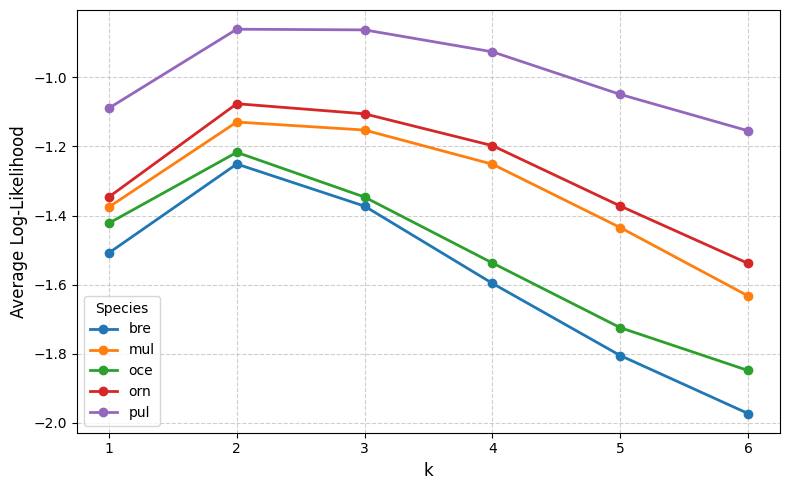

In [ ]:
#by species, single fish

#### USER INPUT ####
species = ['bre','mul','oce','orn','pul']
####################

results = LL_state_by_species(species = species, k=6)

plt.figure(figsize=(8,5))

for species, group in results.groupby('species'):
    plt.plot(
        group['k'],
        group['log_likelihood'],
        marker='o',
        linestyle='-',
        linewidth=2,
        label=species
    )

plt.xlabel("k", fontsize=12)
plt.ylabel("Average Log-Likelihood", fontsize=12)
plt.xticks(sorted(results['k'].unique()))  # ensures all k-values appear
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Species', fontsize=10)
plt.tight_layout()
plt.show()

Order 1: LL=-1.3722
Order 2: LL=-1.1401
Order 3: LL=-1.4448
Order 4: LL=-2.6114
Order 5: LL=-5.7297
Order 6: LL=-9.9652
Order 1: LL=-1.3722
Order 2: LL=-1.1342
Order 3: LL=-1.3769
Order 4: LL=-2.3250
Order 5: LL=-4.8846
Order 6: LL=-8.3781
Order 1: LL=-1.3722
Order 2: LL=-1.1284
Order 3: LL=-1.3090
Order 4: LL=-2.0386
Order 5: LL=-4.0395
Order 6: LL=-6.7910
Order 1: LL=-1.3722
Order 2: LL=-1.1225
Order 3: LL=-1.2411
Order 4: LL=-1.7522
Order 5: LL=-3.1944
Order 6: LL=-5.2039
Order 1: LL=-1.3716
Order 2: LL=-1.1161
Order 3: LL=-1.1726
Order 4: LL=-1.4654
Order 5: LL=-2.3490
Order 6: LL=-3.6165
Order 1: LL=-1.3151
Order 2: LL=-1.0602
Order 3: LL=-1.0560
Order 4: LL=-1.1400
Order 5: LL=-1.4759
Order 6: LL=-2.0099
Order 1: LL=0.2791
Order 2: LL=0.3477
Order 3: LL=0.3603
Order 4: LL=0.3644
Order 5: LL=0.3480
Order 6: LL=0.3041


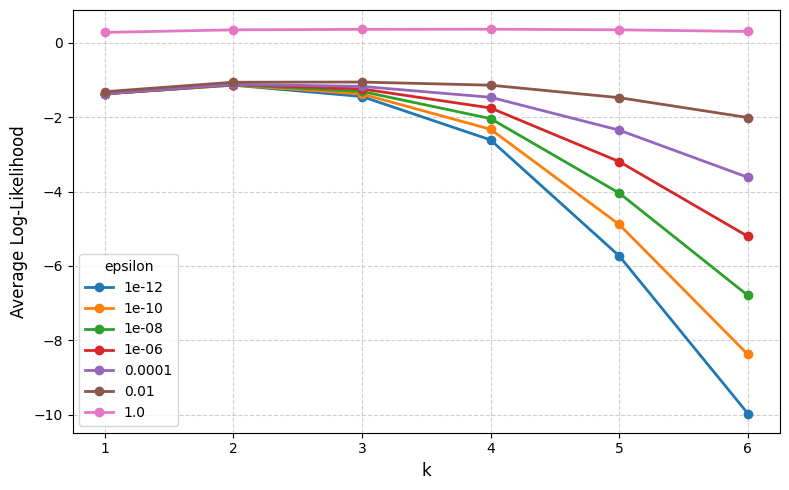

In [ ]:
#before deciding on additive smoothing, which adds a constant to all cells in the transition matrix,
#I looked at adding a small epsilon to the log likelihood calculation instead
#I decided against it eventually because this epsilon idea skews the data more than additive smoothing, 
#since smaller transition probabilities are affected greater than large ones with epsilons

#normalized k-order markov transition probabilities
def find_transitions_normalized_e(lines, k):
    transitions = defaultdict(Counter)
    
    for seq in lines:
        collapsed = collapse_length(seq)
        if len(collapsed) <= k:
            continue
        for t in range(k, len(collapsed)):
            prev = tuple(collapsed[t - k:t])
            curr = collapsed[t]
            transitions[prev][curr] += 1

    # Normalize
    normalized = {}
    for cond, counter in transitions.items():
        total = sum(counter.values())
        normalized[cond] = {s: c / total for s, c in counter.items()}
    return normalized

## log likelihood calculations with epsilon
def ll_e(train_probs, test_probs, epsilon = 1e-8):
    ll = 0.0 #start ll = 0
    total_weight = 0.0 #starting total = 0
    
    for s, nexts in test_probs.items(): #for each prev state in test set
        for s2, p_test in nexts.items(): #for each next state in current prev state
            p_train = train_probs.get(s, {}).get(s2, 0.0) #find prob of same transition in train set, if dne, empty set and 0 probability
            ll += p_test * np.log(p_train + epsilon) #weighted log prob with epsilon
            total_weight += p_test
    
    if total_weight == 0:
        return np.nan
    return ll / total_weight

#find log likelihood for k-order markov transitions
def find_k_trans_e(train_lines, test_lines, evals, k=5):
    results = []
    for e in evals: 
        for k in range(1, k + 1):
            train_trans = find_transitions_normalized_e(train_lines, k=k) #train transition matrix 1-smoothed and normalized
            test_trans = find_state_transitions_count(test_lines, k=k) #test transition matrix unnormalized count data
        
            ll = ll_e(train_trans, test_trans, epsilon=e)
        
            results.append({
                "epsilon": e,
                "k": k,
                "log_likelihood": ll,
                "num_train_states": len(train_trans),
                "num_test_states": len(test_trans),
            })
        
            print(f"Order {k}: LL={ll:.4f}")
    
    df = pd.DataFrame(results)
    return df

###########

evals = [1e-12, 1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1] #tried to break it with high values


#### USER INPUT ####
train_lines = read_lines("corpus_mul_train_full.txt")
test_lines = read_lines("corpus_mul_test_full.txt")
####################

results = find_k_trans_e(train_lines, test_lines, evals = evals, k=6)

plt.figure(figsize=(8,5))

for epsilon, group in results.groupby('epsilon'):
    plt.plot(
        group['k'],
        group['log_likelihood'],
        marker='o',
        linestyle='-',
        linewidth=2,
        label=epsilon
    )

plt.xlabel("k", fontsize=12)
plt.ylabel("Average Log-Likelihood", fontsize=12)
plt.xticks(sorted(results['k'].unique()))  # ensures all k-values appear
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='epsilon', fontsize=10)
plt.tight_layout()
plt.show()

Order 1: LL=-1.4830
Order 2: LL=-1.1222
Order 3: LL=-2.3307
Order 4: LL=-3.9190
Order 5: LL=-3.6214
Order 1: LL=-1.4830
Order 2: LL=-1.1222
Order 3: LL=-2.1333
Order 4: LL=-3.4873
Order 5: LL=-3.2701
Order 1: LL=-1.4830
Order 2: LL=-1.1222
Order 3: LL=-1.9360
Order 4: LL=-3.0556
Order 5: LL=-2.9189
Order 1: LL=-1.4830
Order 2: LL=-1.1222
Order 3: LL=-1.7387
Order 4: LL=-2.6240
Order 5: LL=-2.5678
Order 1: LL=-1.4831
Order 2: LL=-1.1224
Order 3: LL=-1.5421
Order 4: LL=-2.1940
Order 5: LL=-2.2184
Order 1: LL=-1.4856
Order 2: LL=-1.1376
Order 3: LL=-1.2210
Order 4: LL=-1.4801
Order 5: LL=-1.6675
Order 1: LL=-1.5079
Order 2: LL=-1.2510
Order 3: LL=-1.3729
Order 4: LL=-1.5962
Order 5: LL=-1.8048
Order 1: LL=-1.5412
Order 2: LL=-1.3826
Order 3: LL=-1.5622
Order 4: LL=-1.7666
Order 5: LL=-1.9417
Order 1: LL=-1.5883
Order 2: LL=-1.5255
Order 3: LL=-1.7291
Order 4: LL=-1.9023
Order 5: LL=-2.0411


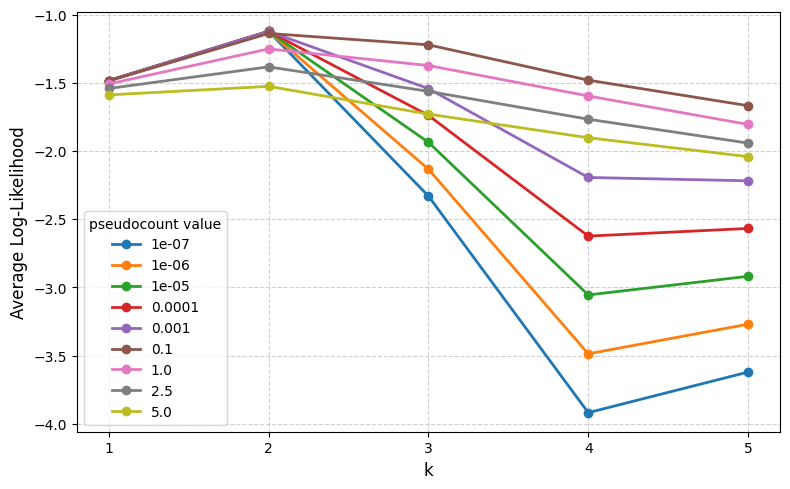

In [5]:
#experimenting with effects of additive smoother values

def find_k_trans_smooth(train_lines, test_lines, smoothers, k=5):
    results = []
    for smoother in smoothers:
        for k in range(1, k + 1):
            train_trans = find_state_transitions_N(train_lines, k=k, smoother = smoother) #train transition matrix 1-smoothed and normalized
            test_trans = find_state_transitions_count(test_lines, k=k) #test transition matrix unnormalized count data
        
            ll = average_log_likelihood(train_trans, test_trans)
        
            results.append({
                "smoother_val": smoother,
                "k": k,
                "log_likelihood": ll,
                "num_train_states": len(train_trans),
                "num_test_states": len(test_trans),
            })
        
            print(f"Order {k}: LL={ll:.4f}")
    
    df = pd.DataFrame(results)
    return df


smoothers = [.0000001, .000001, .00001, .0001, .001, 0.1, 1, 2.5, 5] #also tried to break it


#### USER INPUT ####
train_lines = read_lines("corpus_bre_train_full.txt")
test_lines = read_lines("corpus_bre_test_full.txt")
####################

results = find_k_trans_smooth(train_lines, test_lines, smoothers = smoothers, k=5)

plt.figure(figsize=(8,5))

for smoother, group in results.groupby('smoother_val'):
    plt.plot(
        group['k'],
        group['log_likelihood'],
        marker='o',
        linestyle='-',
        linewidth=2,
        label=smoother
    )

plt.xlabel("k", fontsize=12)
plt.ylabel("Average Log-Likelihood", fontsize=12)
plt.xticks(sorted(results['k'].unique()))  # ensures all k-values appear
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='pseudocount value', fontsize=10)
plt.tight_layout()
plt.show()

Order 1: LL=-2.2386
Order 1: LL=-1.8979
Order 2: LL=-2.1974
Order 2: LL=-2.1218
Order 3: LL=-2.3515
Order 3: LL=-2.0055
Order 4: LL=-2.2762
Order 4: LL=-1.9973
Order 5: LL=-2.2737
Order 5: LL=-2.1641
Order 1: LL=-1.4370
Order 1: LL=-1.4670
Order 2: LL=-1.4511
Order 2: LL=-1.3868
Order 3: LL=-1.6694
Order 3: LL=-1.6078
Order 4: LL=-1.9183
Order 4: LL=-1.7876
Order 5: LL=-2.0764
Order 5: LL=-1.9686
Order 1: LL=-1.6318
Order 1: LL=-1.7123
Order 2: LL=-1.6894
Order 2: LL=-1.7634
Order 3: LL=-2.0556
Order 3: LL=-1.8412
Order 4: LL=-2.1428
Order 4: LL=-1.8872
Order 5: LL=-2.2173
Order 5: LL=-1.8911
Order 1: LL=-1.3432
Order 1: LL=-1.3544
Order 2: LL=-1.3653
Order 2: LL=-1.1734
Order 3: LL=-1.4929
Order 3: LL=-1.3150
Order 4: LL=-1.6729
Order 4: LL=-1.4664
Order 5: LL=-1.8661
Order 5: LL=-1.5759
Order 1: LL=-1.3600
Order 1: LL=-1.2650
Order 2: LL=-1.2592
Order 2: LL=-1.1786
Order 3: LL=-1.4611
Order 3: LL=-1.3771
Order 4: LL=-1.6744
Order 4: LL=-1.5715
Order 5: LL=-1.8236
Order 5: LL=-1.6338


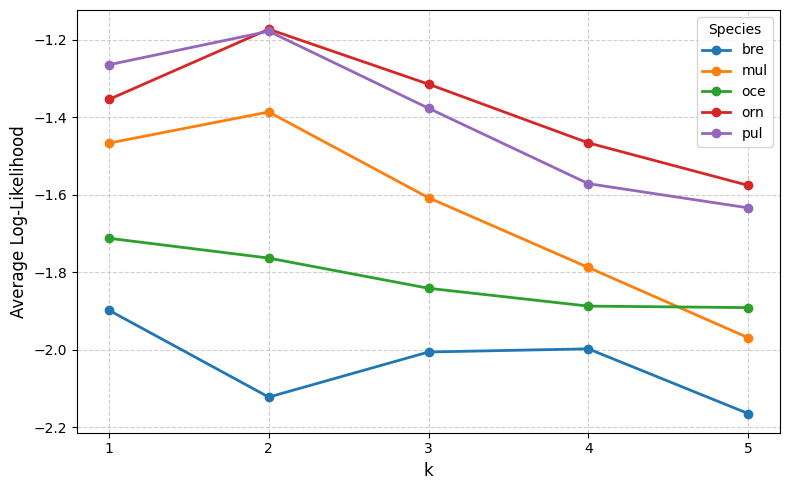

In [6]:
#markov sampling using states of both fish in interaction

#by species

#### USER INPUT ####
species = ['bre','mul','oce','orn','pul']
####################

dom_results, sub_results = LL_state_by_species_2F(species = species, ks=5)

plt.figure(figsize=(8,5))

for species, group in sub_results.groupby('species'):
    plt.plot(
        group['k'],
        group['log_likelihood'],
        marker='o',
        linestyle='-',
        linewidth=2,
        label=species
    )

plt.xlabel("k", fontsize=12)
plt.ylabel("Average Log-Likelihood", fontsize=12)
plt.xticks(sorted(results['k'].unique()))  # ensures all k-values appear
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Species', fontsize=10)
plt.tight_layout()
plt.show()


